In [532]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import torch 
import numpy as np
import plotly
from torch import nn
from sklearn.model_selection import train_test_split

In [533]:
df = pd.read_csv('IBM.csv')
print(df)

             Date         Low        Open   Volume        High       Close  \
0      02-01-1970   17.399618   17.423517   330536   17.483271   17.435469   
1      05-01-1970   17.495220   17.495220   443504   17.602772   17.602772   
2      06-01-1970   17.507170   17.602772   510448   17.638622   17.614723   
3      07-01-1970   17.507170   17.614723   479068   17.626673   17.626673   
4      08-01-1970   17.566921   17.626673   740568   17.662523   17.662523   
...           ...         ...         ...      ...         ...         ...   
13351  06-12-2022  146.699997  147.300003  2847600  147.800003  147.500000   
13352  07-12-2022  146.289993  147.330002  3971300  148.100006  147.270004   
13353  08-12-2022  147.369995  147.899994  2665700  149.149994  147.779999   
13354  09-12-2022  146.970001  147.399994  3047600  148.339996  147.050003   
13355  12-12-2022  146.942596  147.820007  1049947  148.279999  147.589996   

       Adjusted Close  
0            4.003040  
1            4.

In [534]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13356 entries, 0 to 13355
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            13356 non-null  object 
 1   Low             13356 non-null  float64
 2   Open            13356 non-null  float64
 3   Volume          13356 non-null  int64  
 4   High            13356 non-null  float64
 5   Close           13356 non-null  float64
 6   Adjusted Close  13356 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 730.5+ KB


In [535]:
df['Date'] = pd.to_datetime(df['Date'])

/tmp/ipykernel_36650/2394721818.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


In [536]:
df.set_index('Date',inplace=True)

In [537]:
df.head()

,Low,Open,Volume,High,Close,Adjusted Close
Date,,,,,,
1970-02-01,17.399618,17.423517,330536,17.483271,17.435469,4.003040
1970-05-01,17.495220,17.495220,443504,17.602772,17.602772,4.041449
1970-06-01,17.507170,17.602772,510448,17.638622,17.614723,4.044193
1970-07-01,17.507170,17.614723,479068,17.626673,17.626673,4.046936
1970-08-01,17.566921,17.626673,740568,17.662523,17.662523,4.055170


In [538]:
df.tail()

,Low,Open,Volume,High,Close,Adjusted Close
Date,,,,,,
2022-06-12,146.699997,147.300003,2847600,147.800003,147.500000,147.500000
2022-07-12,146.289993,147.330002,3971300,148.100006,147.270004,147.270004
2022-08-12,147.369995,147.899994,2665700,149.149994,147.779999,147.779999
2022-09-12,146.970001,147.399994,3047600,148.339996,147.050003,147.050003
2022-12-12,146.942596,147.820007,1049947,148.279999,147.589996,147.589996


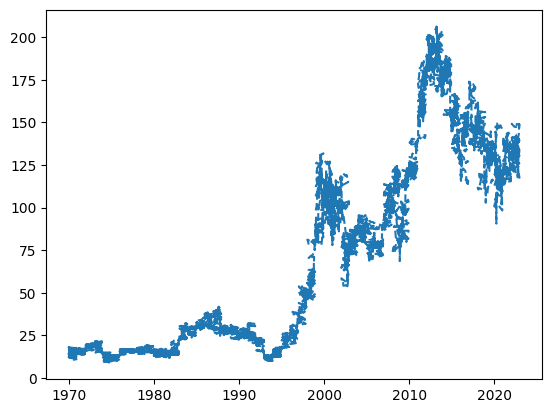

In [539]:
plt.plot(df['Close'], linestyle='--')
plt.show()

In [540]:
class VanillaRNN(nn.Module): 
    
    def __init__(self, len_in, len_h, len_out):
        super(VanillaRNN, self).__init__()
        self.len_h = len_h #size of hidden state
        self.in_h = nn.Linear(len_in + len_h, len_h) #graph module to compute next hidden state 
        self.in_out = nn.Linear(len_in + len_h, len_out) #computes output 

    def forward(self, x, h):
        #here we choose to concatenate the hidden state and input 
        #another approach would be to multiply these vectors 
        combined = torch.cat((x, h), 2) 
        h_out = nn.Tanh(self.in_h(combined)) 
        #we choose to produce an output at each timestep
        y = self.in_out(combined) 
        return y, h_out 

    def init_h(self, batch_size, sequence_length):
        #zero initialization 
        #alternatives include but not limited to Xavier/Kaiminh initialization
        return torch.zeros(batch_size, sequence_length, self.len_h, requires_grad=False)

In [541]:
def train(model, data_loader, loss_function, optim, epochs, device):
    
    losses = [] #group losses for loss visualization 
    
    for epoch in range(epochs):
        
        print("Epoch %d / %d" % (epoch+1, epochs))
        print("-"*10)
    
        for i, (x, y) in enumerate(data_loader):
            
            if i == 0: 
                h_s = model.init_h(x.shape[0], x.shape[1]).to(device) 
            x = x.to(device)
            y = y.to(device)
            print(x.device)
            print(h_s.device)
            y_pred, h_out = model(x, h_s)
            h_s = h_out
            
            loss = loss_function(y_pred, y) 
            losses.append(loss)
        
            optim.zero_grad()
            loss.backward() #backprop 
            optim.step() #update weights

            if(i % 10):
              print("Step: {}/{}, current Epoch loss: {:.4f}".format(i, len(data_loader), loss))  

In [542]:
def load_data(stock, sequence_length):
    # Convert pandas dataframe to numpy array
    data_raw = stock.to_numpy()

    data = []

    # Loop over the stock data to generate sequences of 'sequence_length' consecutive data points
    # This is done because RNNs learn to predict data in a sequence from past sequence
    for index in range(len(data_raw) - sequence_length):
        data.append(data_raw[index: index + sequence_length])

    data = np.array(data)
    print(data.dtype)
    set_size = int(data.shape[0])

    # Generate the train data
    # x_train is all sequences excluding the last data point from each sequence
    x = data[:set_size,:-1,:]
    # y_train is the last data point from each sequence
    y = data[:set_size,-1,:]

    # Return the train and test data
    return [x, y]

In [543]:
ibm_df = pd.read_csv('IBM.csv')
ibm_df['Date'] = pd.to_datetime(ibm_df['Date'])
ibm_df.set_index('Date',inplace=True)


# Get the number of rows in the DataFrame
num_rows = ibm_df.shape[0]

# Compute the split point
split_point = int(num_rows*0.8)

# Split the DataFrame
train_df = ibm_df.iloc[:split_point]
test_df = ibm_df.iloc[split_point:]

x_train, y_train = load_data(train_df, 10) 
x_test, y_test = load_data(test_df, 10) 

float64
float64


/tmp/ipykernel_36650/1695855018.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  ibm_df['Date'] = pd.to_datetime(ibm_df['Date'])


In [544]:
print(train_df.head()) #to ensure no shuffling accidentally occurred 

                  Low       Open  Volume       High      Close  Adjusted Close
Date                                                                          
1970-02-01  17.399618  17.423517  330536  17.483271  17.435469        4.003040
1970-05-01  17.495220  17.495220  443504  17.602772  17.602772        4.041449
1970-06-01  17.507170  17.602772  510448  17.638622  17.614723        4.044193
1970-07-01  17.507170  17.614723  479068  17.626673  17.626673        4.046936
1970-08-01  17.566921  17.626673  740568  17.662523  17.662523        4.055170


In [545]:
print(test_df.tail())

                   Low        Open   Volume        High       Close  \
Date                                                                  
2022-06-12  146.699997  147.300003  2847600  147.800003  147.500000   
2022-07-12  146.289993  147.330002  3971300  148.100006  147.270004   
2022-08-12  147.369995  147.899994  2665700  149.149994  147.779999   
2022-09-12  146.970001  147.399994  3047600  148.339996  147.050003   
2022-12-12  146.942596  147.820007  1049947  148.279999  147.589996   

            Adjusted Close  
Date                        
2022-06-12      147.500000  
2022-07-12      147.270004  
2022-08-12      147.779999  
2022-09-12      147.050003  
2022-12-12      147.589996  


In [546]:
print("Train input data shape: {}, target shape: {}".format(x_train.shape, y_train.shape)) 

Train input data shape: (10674, 9, 6), target shape: (10674, 6)


In [547]:
print("Test input data shape: {}, target shape: {}".format(x_test.shape, y_test.shape)) 

Test input data shape: (2662, 9, 6), target shape: (2662, 6)


In [548]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [549]:
train_set = torch.utils.data.TensorDataset(x_train,y_train)
test_set = torch.utils.data.TensorDataset(x_test,y_test)

In [550]:
NUM_EPOCHS = 50 
BATCH_SIZE = 30 
LEARNING_RATE = 3e-4
INPUT_DIM = 6 
OUTPUT_DIM = 1 
HIDDEN_DIM = 32 

In [551]:
train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False)

In [552]:
model = VanillaRNN(len_in=INPUT_DIM, len_h=HIDDEN_DIM, len_out=OUTPUT_DIM)

In [553]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [554]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train(model=model, data_loader=train_loader, loss_function=torch.nn.functional.cross_entropy, optim=optimizer, epochs=NUM_EPOCHS, device=device)